In [ ]:
! nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEmo1_jQD0PBjO-tpAuKc4_OgF0raU9h0Xj1fWTsx2hBXBXm94o0Go
Mounted at /content/gdrive


In [ ]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [ ]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/EVA4P2_S6_Zipdataset/EVA4P2_S6_GAN_Cars_better_Size128.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 36.4 ms, sys: 15.3 ms, total: 51.7 ms
Wall time: 665 ms


In [ ]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [ ]:
class_list       = [0]
class_names_dict = {0:'Cars'}
class_names      = ['Cars']

In [ ]:
dataset          = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*1)}') 
train_len = int(len(dataset)*1)

Dataset Length:505, Train Data length: 505


In [ ]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 617 (delta 2), reused 0 (delta 0), pack-reused 609
Receiving objects: 100% (617/617), 21.93 MiB | 26.26 MiB/s, done.
Resolving deltas: 100% (325/325), done.


In [ ]:
%cd '/content/Deep_Learning_EVA4_Phase2/S6_GAN'
! ls

/content/Deep_Learning_EVA4_Phase2/S6_GAN
EVA4P2_S6_GAN_V2.ipynb	EVA4P2_S6_GAN_V3.ipynb	README.md  src


In [ ]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S6_GAN/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.losses  import Train_Losses
from src.losses  import Test_Losses

In [ ]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Resize(128, 128),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                    ])

In [ ]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
print(f'Train Length {len(train)}')

Train Length 505


In [ ]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, num_workers=2, pin_memory = True)

In [ ]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [ ]:
dataiter = iter(train_loader)

In [ ]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show() 

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_DIM = (128, 128, 3)

In [ ]:
def get_sample_image(G, n_noise):
    """
        Generate sample 10 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 128, 128).permute(0, 2, 3, 1)    #Modify axes to (10, 28, 28, 3) via permute
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # Conv-1 -> 128 -> 64
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # Conv-2 -> 64 -> 32
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # Conv-3 -> 32 -> 16
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # Conv-4 -> 16 -> 8
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # Conv-5 -> 8 -> 4
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # Conv-6 -> 4 -> 2
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )        
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    def __init__(self, out_channel=3, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)        
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*32),
            nn.ReLU(),
        ) # 100 -> 2048
        self.conv = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32768 -> 8x8x512    
            nn.ConvTranspose2d(32, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 8x8x512 -> 16x16x256
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 16x16x256 -> 32x32x128
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 32x32x64 -> 64x64x64                   
            nn.ConvTranspose2d(64, out_channel, 4, stride=2, padding=1, bias=False),
            # 64x64x64 -> 128x128x3
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 32, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
D.apply(weights_init)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)
G.apply(weights_init)

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
summary(D, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          13,824
       BatchNorm2d-2          [-1, 512, 64, 64]           1,024
         LeakyReLU-3          [-1, 512, 64, 64]               0
            Conv2d-4          [-1, 256, 32, 32]       1,179,648
       BatchNorm2d-5          [-1, 256, 32, 32]             512
         LeakyReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         294,912
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]         147,456
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        LeakyReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         147,456
      BatchNorm2d-14            [-1, 12

In [ ]:
summary(G, input_size=(1,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]         206,848
              ReLU-2                 [-1, 2048]               0
            Conv2d-3             [-1, 32, 8, 8]           9,216
       BatchNorm2d-4             [-1, 32, 8, 8]              64
              ReLU-5             [-1, 32, 8, 8]               0
   ConvTranspose2d-6          [-1, 256, 16, 16]         131,072
       BatchNorm2d-7          [-1, 256, 16, 16]             512
              ReLU-8          [-1, 256, 16, 16]               0
   ConvTranspose2d-9          [-1, 128, 32, 32]         524,288
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
  ConvTranspose2d-12           [-1, 64, 64, 64]         131,072
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.003, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.003, betas=(0.5, 0.999))

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)

D_loss_all, G_loss_all, img_list = [], [], []
step = 0

In [ ]:
max_epoch = 2000
n_noise = 100
batch_size = 32

In [ ]:
D_prev_save = f'/content/gdrive/My Drive/EVA4P2_S6_Training/Model_Weights_D0911/D_GPU_495_20200911120402.pt'
D.load_state_dict(torch.load(D_prev_save))
G_prev_save = f'/content/gdrive/My Drive/EVA4P2_S6_Training/Model_Weights_D0911/G_GPU_495_20200911120402.pt'
G.load_state_dict(torch.load(G_prev_save))

<All keys matched successfully>

In [ ]:
for epoch in range(496, max_epoch):
    D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
    D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

    for idx, images in enumerate(train_loader):

        batch = images[0].shape[0]

        # Training Discriminator with real images
        D.zero_grad()
        D_labels = torch.full((batch,), real_label, dtype=torch.float, device=DEVICE)
        real_img = images[0].to(DEVICE)
        real_outputs = D(real_img)
        D_real_loss = criterion(real_outputs, D_labels)
        D_real_loss.backward()

        # Training Discriminator with generated fake images. Also update D
        z = torch.randn(batch, n_noise).to(DEVICE)
        fake_img     = G(z)
        D_labels.fill_(fake_label)
        fake_outputs = D(fake_img)
        D_fake_loss = criterion(fake_outputs, D_labels)
        D_fake_loss.backward()        
        D_loss = D_real_loss + D_fake_loss        
        D_opt.step()

        # Training Generator. Also update G
        D.zero_grad()     
        G.zero_grad()     
        D_labels.fill_(real_label)
        z = torch.randn(batch, n_noise).to(DEVICE)
        fake_img = G(z)
        fake_outputs = D(fake_img)
        G_loss = criterion(fake_outputs, D_labels)        
        G_loss.backward()
        G_opt.step()
        
        if step % 150 == 0 or ((epoch == max_epoch-1) and (idx == len(train_loader)-1)):
            print(f'Epoch: {epoch+1}/{max_epoch}, Step: {step}, D Loss: {D_loss.item():.6f}, G Loss: {G_loss.item():.6f}')
            G.eval()
            img = get_sample_image(G, n_noise)
            t = datetime.now()
            time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")
            imsave(f'/content/gdrive/My Drive/EVA4P2_S6_Training/Images_Size128_D0911/DCGAN_{epoch+1}_{step:05d}_{time_stamp}.jpg', img[0])
            
            fake_img = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_img, padding=2, normalize=True)) 
            G.train()
         
        step += 1  

    D_loss_all.append(D_loss.item())
    G_loss_all.append(G_loss.item())
    print(f'Epoch: {epoch+1}/{max_epoch},   D Loss: {D_loss.item():.6f}, G Loss: {G_loss.item():.6f}')

    if epoch % 45 == 0 or (epoch == (max_epoch-1) and (idx == len(train_loader)-1)): ### Keep the model in Gpu & Save the model values in intermittent epochs
        t = datetime.now()
        time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")         
        torch.save(D.state_dict(),f'/content/gdrive/My Drive/EVA4P2_S6_Training/Model_Weights_D0911/D_GPU_{epoch}_{time_stamp}.pt')
        torch.save(G.state_dict(),f'/content/gdrive/My Drive/EVA4P2_S6_Training/Model_Weights_D0911/G_GPU_{epoch}_{time_stamp}.pt') 
        print(f'GPU model saved in epoch {epoch+1}/{max_epoch}')                           
         
    if (epoch == (max_epoch-1) and (idx == len(train_loader)-1)):    ### Convert the model to CPU & save the model values on final epoch              
        t = datetime.now()
        time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")
        D.eval()
        D.to('cpu')
        traced_D = torch.jit.trace(D,torch.randn(1,3,128,128))      
        traced_D.save(f'/content/gdrive/My Drive/EVA4P2_S6_Training/Model_Weights_D0911/D_CPU_{epoch}_{time_stamp}.pt')
        G.eval()
        G.to('cpu')
        traced_G = torch.jit.trace(G,torch.randn(1,1,100))
        traced_G.save(f'/content/gdrive/My Drive/EVA4P2_S6_Training/Model_Weights_D0911/G_CPU_{epoch}_{time_stamp}.pt') 
        print(f' **** CPU model Saved in epoch:{epoch+1}/{max_epoch}')
        D.to(DEVICE)      
        G.to(DEVICE)
        D.train()
        G.train()

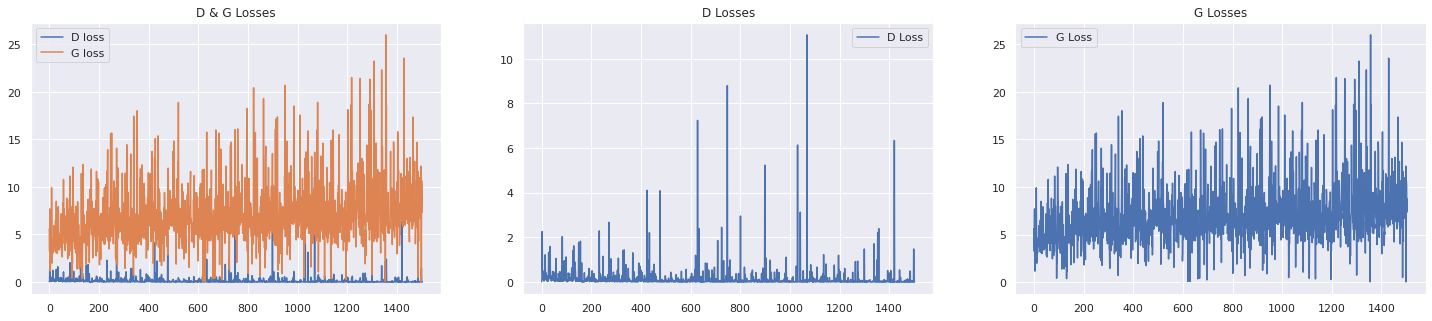

In [ ]:
figure = plt.figure(figsize=(25,5))
labels = ['Loss Plots']

plt.subplot(1,3,1)
plt.title("D & G Losses")
plt.plot(D_loss_all,label='D loss')
plt.plot(G_loss_all,label='G loss')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("D Losses")
plt.plot(D_loss_all,label='D Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("G Losses")
plt.plot(G_loss_all,label='G Loss')
plt.legend(loc="best")

In [ ]:
len(D_loss_all)

1504

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, metadata=dict(artist='Me'), bitrate=1800)
ani.save(f'/content/gdrive/My Drive/EVA4P2_S6_Training/animation_2.mp4', writer=writer)

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[1])

In [ ]:
# Real Image
t = Image.open(dataset[128][0])
t = (train_transforms(t).permute(1, 2, 0)+1)/2.
imshow(t)